### Evaluation metrics for Classification
Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

#### 4.1 Evaluation metrics: session overview
* Dataset: https://www.kaggle.com/blastchar/telco-customer-churn
* https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv

Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [6]:
df = pd.read_csv('../03-classification/notebook/WA_Fn-UseC_-Telco-Customer-Churn.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)
df.churn = (df.churn == 'yes').astype(int)

In [7]:
df_full_train , df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train , df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [8]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [9]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [10]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

#### 4.2 Accuracy and dummy model
* valuate the model on different thresholds
* Check the accuracy of dummy baselines

In [11]:
len(y_val)

1409

In [12]:
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

In [13]:
from sklearn.metrics import accuracy_score

In [14]:
accuracy_score(y_val, churn_decision)

0.8034066713981547

In [15]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.513
0.10 0.608
0.15 0.662
0.20 0.703
0.25 0.735
0.30 0.758
0.35 0.764
0.40 0.782
0.45 0.791
0.50 0.803
0.55 0.802
0.60 0.796
0.65 0.789
0.70 0.766
0.75 0.742
0.80 0.729
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


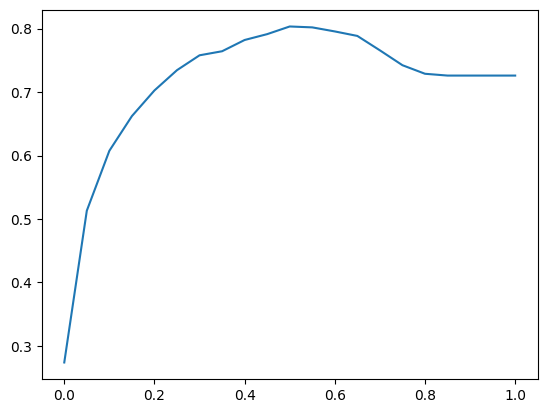

In [16]:
plt.plot(thresholds, scores)

In [17]:
from collections import Counter

In [18]:
Counter(y_pred >= 1.0)

Counter({np.False_: 1409})

In [19]:
1 - y_val.mean()

np.float64(0.7260468417317246)

### 4.3 Confusion Table

* different types of errors and correct decisions
* arranging then in a table

In [20]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [21]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred <= t)

In [22]:
predict_positive[:5]

array([False, False, False,  True, False])

In [23]:
actual_positive[:5]

array([False, False, False,  True, False])

In [24]:
tp = (predict_positive & actual_positive).sum()
tn = (predict_negative & actual_negative).sum()

fp = (predict_positive & actual_negative).sum()
fn = (predict_negative & actual_positive).sum()

In [25]:
confustion_matrix = np.array([
    [tn, fp],
    [fn, fp]
])
confustion_matrix

array([[920, 103],
       [174, 103]])

In [26]:
(confustion_matrix/confustion_matrix.sum()).round(2)

array([[0.71, 0.08],
       [0.13, 0.08]])

#### 4.4 Precision Re-Call

In [27]:
p = tp / (tp + fp)
p

np.float64(0.6730158730158731)

In [28]:
r = tp / ( tp + fn)
r

np.float64(0.5492227979274611)

#### 4.5 ROC Curves

* Receiver operatting characteristic
* TPR and FRP

In [29]:
tpr = tp / (tp + fn)
tpr

np.float64(0.5492227979274611)

In [30]:
fpr = fp / (fp + tn)
fpr

np.float64(0.10068426197458455)

In [31]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [32]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.fn)
# df_scores[::10]

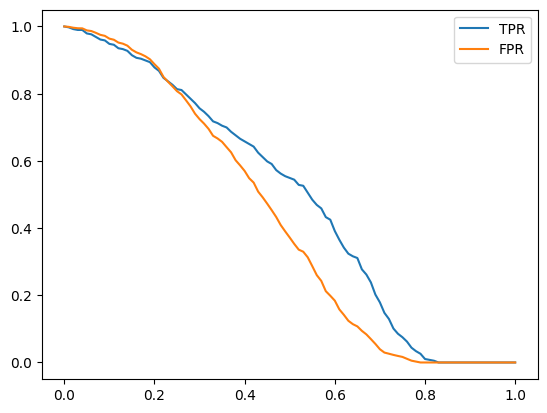

In [33]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

### Random model

In [34]:
np.random.seed(1)
y_ran = np.random.uniform(0, 1, size=len(y_val))

In [35]:
((y_ran >= 0.5) == y_val).mean()

np.float64(0.5017743080198722)

In [36]:
def tpr_fpr_dataframe(y_val, y_pred):
    
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
        
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        scores.append((t, tp, fp, fn, tn))
        
    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.tp + df_scores.fn)
    df_scores['fpr'] = df_scores.fp / (df_scores.fp + df_scores.fn)
    # df_scores[::10]
    
    return df_scores

In [37]:
df_ran = tpr_fpr_dataframe(y_val, y_ran)

In [38]:
df_ran[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,39,100,0.898964,0.959459
20,0.2,307,822,79,201,0.795337,0.912320
30,0.3,276,724,110,299,0.715026,0.868106
40,0.4,237,624,149,399,0.613990,0.807245
50,0.5,202,518,184,505,0.523316,0.737892
60,0.6,161,409,225,614,0.417098,0.645110
70,0.7,121,302,265,721,0.313472,0.532628
80,0.8,78,206,308,817,0.202073,0.400778
90,0.9,40,101,346,922,0.103627,0.225951


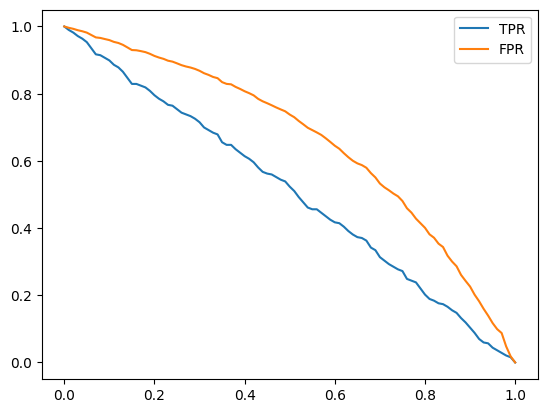

In [39]:
plt.plot(df_ran.threshold, df_ran['tpr'], label='TPR')
plt.plot(df_ran.threshold, df_ran['fpr'], label='FPR')
plt.legend()

### Ideal Model

In [40]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(np.int64(1023), np.int64(386))

In [41]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos])

In [42]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [43]:
1 - y_val.mean()

np.float64(0.7260468417317246)

In [44]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

np.float64(1.0)

In [45]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

In [46]:
df_ideal[::10]

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.0
10,0.1,386,882,0,141,1.000000,1.0
20,0.2,386,741,0,282,1.000000,1.0
30,0.3,386,600,0,423,1.000000,1.0
40,0.4,386,459,0,564,1.000000,1.0
50,0.5,386,319,0,704,1.000000,1.0
60,0.6,386,178,0,845,1.000000,1.0
70,0.7,386,37,0,986,1.000000,1.0
80,0.8,282,0,104,1023,0.730570,0.0
90,0.9,141,0,245,1023,0.365285,0.0


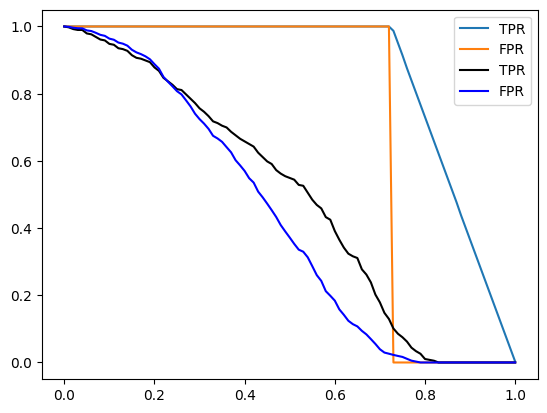

In [47]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')

plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')
plt.legend()

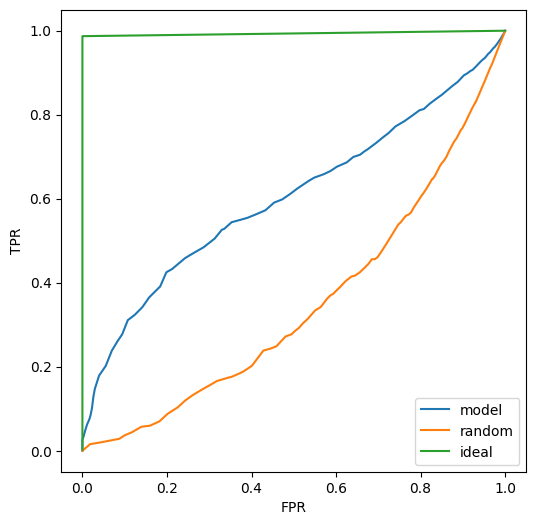

In [48]:
plt.figure(figsize=(6, 6))

plt.plot(df_scores.fpr, df_scores.tpr, label='model') 
plt.plot(df_ran.fpr, df_ran.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

In [49]:
from sklearn.metrics import roc_curve

In [50]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

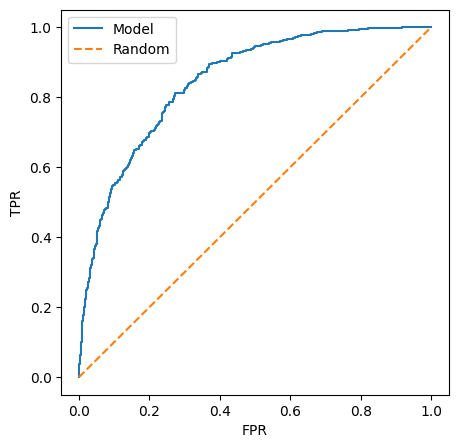

In [51]:
plt.figure(figsize=(5, 5))

plt.plot(fpr, tpr, label='Model')
plt.plot([0, 1], [0, 1], label='Random', linestyle='--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

### 4.6 ROC AUC

* Area under the ROC curve - useful metric
* Interpretation of AUC

In [52]:
from sklearn.metrics import auc

In [53]:
auc(fpr, tpr)

np.float64(0.8463044282031412)

In [54]:
auc(df_scores.fpr, df_scores.tpr)

np.float64(0.6030335654739036)

In [55]:
auc(df_ideal.fpr, df_ideal.tpr)

np.float64(0.9935233160621761)

In [56]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
auc(df_scores.fpr, df_scores.tpr)

np.float64(0.6030335654739036)

In [57]:
from sklearn.metrics import roc_auc_score

In [58]:
roc_auc_score(y_val, y_pred)

np.float64(0.8463044282031412)

In [59]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [60]:
import random

In [61]:
n = 10000000
success = 0
for i in range(n):
    pos_ind = random.randint(0, len(pos) -1)
    neg_ind = random.randint(0, len(neg) -1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1
        

success / n
    

0.8463001

In [62]:
n = 10000
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

In [63]:
(pos[pos_ind] > neg[neg_ind]).mean()

np.float64(0.8381)

### 4.7 Cross-Validation

* evaluating the same model on different subsets of data
* getting the average prediction and the spread within predictions

In [100]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    df = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    
    model = LogisticRegression(C=C, max_iter=10000)
    model.fit(X_train, y_train)
    
    return dv, model
    

In [101]:
dv, model = train(df_train, y_train, C=10)

In [102]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')
    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]
    
    return y_pred    

In [103]:
y_pred = predict(df_val, dv, model)

In [104]:
from sklearn.model_selection import KFold

In [105]:
from tqdm.auto import tqdm

In [110]:
n_splits = 5 

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    scores = []
    
    
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
        
        y_train = df_train.churn.values
        y_val = df_val.churn.values
        
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

 14%|█▍        | 1/7 [00:01<00:11,  1.90s/it]

C=0.001 0.825 +- 0.009


 29%|██▊       | 2/7 [00:08<00:21,  4.37s/it]

C=0.01 0.840 +- 0.008


 43%|████▎     | 3/7 [00:17<00:26,  6.70s/it]

C=0.1 0.842 +- 0.007


 57%|█████▋    | 4/7 [00:24<00:19,  6.66s/it]

C=0.5 0.842 +- 0.007


 71%|███████▏  | 5/7 [00:31<00:14,  7.07s/it]

C=1 0.842 +- 0.007


 86%|████████▌ | 6/7 [00:44<00:08,  8.95s/it]

C=5 0.842 +- 0.007


100%|██████████| 7/7 [00:56<00:00,  8.01s/it]

C=10 0.842 +- 0.007


In [112]:
scores

[np.float64(0.8439018454992897),
 np.float64(0.8447246225665475),
 np.float64(0.8336343568131647),
 np.float64(0.8347848852081603),
 np.float64(0.8519853471808226)]

In [113]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)
        
auc = roc_auc_score(y_test, y_pred)
auc

np.float64(0.8584005005037537)

In [75]:
len(train_idx), len(val_idx)

(5070, 564)

### 4.8 Summary

* Metric
* accuracy
* precision
*

In [76]:
len(df_full_train)

5634